<a href="https://colab.research.google.com/github/ernestojr-7/Sumarizacao-de-textos/blob/main/Alg_de_sumarizacao_Luhn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sumarização de textos com o Algoritmo de Luhn

- [link do artigo](https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf)

## Preparação do texto de exemplo

In [74]:
import re
import nltk
import string
import heapq

In [75]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [76]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
texto_original = """A inteligência artificial é a inteligência similar à humana máquinas. 
                    Definem como o estudo de agente artificial com inteligência. 
                    Ciência e engenharia de produzir máquinas com inteligência. 
                    Resolver problemas e possuir inteligência. 
                    Relacionada ao comportamento inteligente. 
                    Construção de máquinas para raciocinar. 
                    Aprender com os erros e acertos. 
                    Inteligência artificial é raciocinar nas situações do cotidiano."""
texto_original = re.sub(r'\s+', ' ', texto_original)
texto_original

'A inteligência artificial é a inteligência similar à humana máquinas. Definem como o estudo de agente artificial com inteligência. Ciência e engenharia de produzir máquinas com inteligência. Resolver problemas e possuir inteligência. Relacionada ao comportamento inteligente. Construção de máquinas para raciocinar. Aprender com os erros e acertos. Inteligência artificial é raciocinar nas situações do cotidiano.'

In [78]:
stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

In [79]:
stopwords.append('ser')
stopwords.append('além')

In [80]:
import spacy

In [81]:
!python -m spacy download pt

     |████████████████████████████████| 21.2 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [82]:
pln = spacy.load('pt')

In [83]:
def pre_processamento(texto):
  texto = texto.lower()
  texto = re.sub(r" +", ' ', texto)

  documento = pln(texto)
  tokens = []
  for token in documento:
    tokens.append(token.lemma_)
  
  tokens = [palavra for palavra in tokens if palavra not in stopwords and palavra not in string.punctuation]
  texto_formatado = ' '.join([str(elemento) for elemento in tokens if not elemento.isdigit()])
  
  return texto_formatado

## Função para calcular a nota das sentenças

In [84]:
def calcula_nota_sentenca(sentencas, palavras_importantes, distancia):
  notas = []
  indice_sentenca = 0

  for sentenca in [nltk.word_tokenize(sentenca.lower()) for sentenca in sentencas]:
    indice_palavra = []
    for palavra in palavras_importantes:
      try:
        indice_palavra.append(sentenca.index(palavra))
      except ValueError:
        pass
    
    indice_palavra.sort()

    if len(indice_palavra) == 0:
      continue

    lista_grupos = []
    grupo = [indice_palavra[0]]
    i = 1
    while i < len(indice_palavra):
      if indice_palavra[i] - indice_palavra[i - 1] < distancia:
        grupo.append(indice_palavra[i])
      else:
        lista_grupos.append(grupo[:])
        grupo = [indice_palavra[i]]
      i += 1
    lista_grupos.append(grupo)

    nota_maxima_grupo = 0
    for g in lista_grupos:
      palavras_importantes_no_grupo = len(g)
      total_palavras_no_grupo = g[-1] - g[0] + 1
      nota = 1.0 * palavras_importantes_no_grupo**2 / total_palavras_no_grupo

      if nota > nota_maxima_grupo:
        nota_maxima_grupo = nota

    notas.append((nota_maxima_grupo, indice_sentenca))
    indice_sentenca += 1

  return notas

## Função para sumarizar os textos

In [85]:
def sumarizar(texto, top_n_palavras, distancia, quantidade_sentencas):
  sentencas_originais = [sentenca for sentenca in nltk.sent_tokenize(texto)]
  sentencas_formatadas = [pre_processamento(sentenca_original) for sentenca_original in sentencas_originais]
  palavras = [palavra.lower() for sentenca in sentencas_formatadas for palavra in nltk.tokenize.word_tokenize(sentenca)]
  frequencia = nltk.FreqDist(palavras)
  top_n_palavras = [palavra[0] for palavra in frequencia.most_common(top_n_palavras)]
  notas_sentencas = calcula_nota_sentenca(sentencas_formatadas, top_n_palavras, distancia)
  melhores_sentencas = heapq.nlargest(quantidade_sentencas, notas_sentencas)
  melhores_sentencas = [sentencas_originais[i] for (nota, i) in melhores_sentencas]
  
  return sentencas_originais, melhores_sentencas, notas_sentencas

In [86]:
sentencas_originais, melhores_sentencas, notas_sentencas = sumarizar(texto_original, 5, 3, 3)

In [87]:
sentencas_originais

['A inteligência artificial é a inteligência similar à humana máquinas.',
 'Definem como o estudo de agente artificial com inteligência.',
 'Ciência e engenharia de produzir máquinas com inteligência.',
 'Resolver problemas e possuir inteligência.',
 'Relacionada ao comportamento inteligente.',
 'Construção de máquinas para raciocinar.',
 'Aprender com os erros e acertos.',
 'Inteligência artificial é raciocinar nas situações do cotidiano.']

In [88]:
melhores_sentencas

['Construção de máquinas para raciocinar.',
 'A inteligência artificial é a inteligência similar à humana máquinas.',
 'Ciência e engenharia de produzir máquinas com inteligência.']

In [89]:
notas_sentencas

[(2.6666666666666665, 0),
 (2.0, 1),
 (2.0, 2),
 (1.0, 3),
 (1.3333333333333333, 4),
 (3.0, 5)]

## Visualização do resumo

In [90]:
def visualiza_resumo(titulo, lista_sentencas, melhores_sentencas):
  from IPython.core.display import HTML
  texto = ''

  display(HTML(f'<h1>Resumo do texto - {titulo}</h1>'))
  for i in lista_sentencas:
    if i in melhores_sentencas:
      texto += str(i).replace(i, f"<mark>{i}</mark>")
    else:
      texto += i
  display(HTML(f""" {texto} """))

In [91]:
visualiza_resumo('Teste', sentencas_originais, melhores_sentencas)

## Extração de texto da internet

In [92]:
!pip install goose3

In [93]:
from goose3 import Goose

In [94]:
g = Goose()
url = 'https://iaexpert.academy/2020/11/09/ia-preve-resultado-das-eleicoes-americanas/'
artigo = g.extract(url)

In [95]:
artigo.cleaned_text

'Nas eleições presidenciais americanas de 2016, a maioria das predições apontavam para a vitória de Hillary Clinton. Entretanto, a história nos mostrou o resultado oposto, e Donald Trump foi o presidente nos últimos 4 anos. Desta vez, os estatísticos reexaminaram seus modelos, para aumentar o grau de confiabilidade nos seus resultados. Nesta tentativa de otimização das predições, a inteligência artificial certamente não ficou de fora.\n\nO modelo desenvolvido pelo Dr. Hernan Makse, físico estatístico da Universidade da Cidade de Nova York, baseou suas predições em uma rede neural treinada para processar os sentimentos expressos nas redes sociais. O algoritmo fez a análise de cerca de 1 bilhão de tweets para chegar a uma estimativa dos resultados do pleito. No dia da eleição, 3 de novembro, o modelo estava indicando a vitória de Joe Biden.\n\nO Dr. Makse disse que seu trabalho começou já na eleição de 2016, e foi testado novamente nas eleições na Argentina ano passado. Desta vez, o mode

In [96]:
sentencas_originais, melhores_sentencas, notas_sentencas = sumarizar(artigo.cleaned_text, 300, 10, 5)

In [97]:
sentencas_originais

['Nas eleições presidenciais americanas de 2016, a maioria das predições apontavam para a vitória de Hillary Clinton.',
 'Entretanto, a história nos mostrou o resultado oposto, e Donald Trump foi o presidente nos últimos 4 anos.',
 'Desta vez, os estatísticos reexaminaram seus modelos, para aumentar o grau de confiabilidade nos seus resultados.',
 'Nesta tentativa de otimização das predições, a inteligência artificial certamente não ficou de fora.',
 'O modelo desenvolvido pelo Dr. Hernan Makse, físico estatístico da Universidade da Cidade de Nova York, baseou suas predições em uma rede neural treinada para processar os sentimentos expressos nas redes sociais.',
 'O algoritmo fez a análise de cerca de 1 bilhão de tweets para chegar a uma estimativa dos resultados do pleito.',
 'No dia da eleição, 3 de novembro, o modelo estava indicando a vitória de Joe Biden.',
 'O Dr. Makse disse que seu trabalho começou já na eleição de 2016, e foi testado novamente nas eleições na Argentina ano pas

In [98]:
melhores_sentencas

['O modelo desenvolvido pelo Dr. Hernan Makse, físico estatístico da Universidade da Cidade de Nova York, baseou suas predições em uma rede neural treinada para processar os sentimentos expressos nas redes sociais.',
 'A participação em redes sociais costuma ser maior nas cidades grandes, que de fato têm preferência por um dos candidatos, e o modelo deve ser corrigido para levar em consideração também a opinião das pessoas que não são ativas neste ambiente virtual.',
 'O trabalho não depende apenas da coleta dos dados, mas também de um tratamento estatístico adequado para levar em consideração duas variáveis externas: o viés de amostragem e a taxa de comparecimento.',
 'O segundo fator se deve à não-obrigatoriedade de votação nos Estados Unidos, ou seja, por mais que uma pessoa tenha sua preferência, pode ser que ela não compareça aos locais de votação para efetivá-la.',
 'Quando seu modelo foi usado para predizer os resultados da eleição corrente usando dados brutos, Joe Biden aparece

In [99]:
notas_sentencas

[(10.0, 0),
 (10.0, 1),
 (10.0, 2),
 (8.0, 3),
 (25.0, 4),
 (12.0, 5),
 (9.0, 6),
 (10.083333333333334, 7),
 (11.0, 8),
 (18.0, 9),
 (10.0, 10),
 (23.0, 11),
 (16.055555555555557, 12),
 (10.0, 13),
 (14.0, 14),
 (14.0, 15),
 (15.058823529411764, 16),
 (15.0, 17),
 (10.0, 18)]

In [100]:
visualiza_resumo(artigo.title, sentencas_originais, melhores_sentencas)

## Leitura de artigos de feed de notícias (RSS)

In [101]:
!pip install feedparser

In [102]:
import feedparser

In [103]:
from bs4 import BeautifulSoup
import os
import json

In [104]:
url = 'https://iaexpert.academy/feed/'
feed = feedparser.parse(url)

In [105]:
feed.entries

[{'author': 'Jones Granatyr',
  'author_detail': {'name': 'Jones Granatyr'},
  'authors': [{'name': 'Jones Granatyr'}],
  'comments': 'https://iaexpert.academy/2022/01/04/componentes-da-logica-fuzzy/#respond',
  'content': [{'base': 'https://iaexpert.academy/feed/',
    'language': None,
    'type': 'text/html',
    'value': '<p>Veja nesta aula noções sobre componentes da Lógica Fuzzy. A aula faz parte do curso &#8220;Lógica Fuzzy com Python: O Guia para Iniciantes&#8221;.</p>\n\n\n\n<p>O curso está disponível para <a href="https://iaexpert.academy/assinatura" rel="noreferrer noopener" target="_blank">assinantes</a> IA Expert Academy.</p>\n\n\n\n<p>Curso na <a href="https://www.udemy.com/course/logica-fuzzy-com-python-o-guia-para-iniciantes/?referralCode=1EAF979D88304B25FBEA" rel="noreferrer noopener" target="_blank">Udemy.</a></p>\n\n\n\n<figure class="wp-block-embed"><div class="wp-block-embed__wrapper">\n<div class="ast-oembed-container"></div>\n</div></figure>'}],
  'guidislink': F

In [106]:
for e in feed.entries:
  print(e.title)
  print(e.links[0].href)
  print(e.content[0].value)

Componentes da Lógica Fuzzy
https://iaexpert.academy/2022/01/04/componentes-da-logica-fuzzy/?utm_source=rss&utm_medium=rss&utm_campaign=componentes-da-logica-fuzzy
<p>Veja nesta aula noções sobre componentes da Lógica Fuzzy. A aula faz parte do curso &#8220;Lógica Fuzzy com Python: O Guia para Iniciantes&#8221;.</p>



<p>O curso está disponível para <a href="https://iaexpert.academy/assinatura" rel="noreferrer noopener" target="_blank">assinantes</a> IA Expert Academy.</p>



<p>Curso na <a href="https://www.udemy.com/course/logica-fuzzy-com-python-o-guia-para-iniciantes/?referralCode=1EAF979D88304B25FBEA" rel="noreferrer noopener" target="_blank">Udemy.</a></p>



<figure class="wp-block-embed"><div class="wp-block-embed__wrapper">
<div class="ast-oembed-container"></div>
</div></figure>
Estrutura de repetição “enquanto” (while) com Python
https://iaexpert.academy/2021/12/30/estrutura-de-repeticao-enquanto-while-com-python/?utm_source=rss&utm_medium=rss&utm_campaign=estrutura-de-repe

In [107]:
e.content[0].value

'<p>O concreto é o material de construção mais utilizado no mundo, ultrapassando o segundo lugar, o aço, em mais de 20 vezes. Entretanto, a produção do cimento, seu principal ingrediente, resulta em cerca de 8% de toda a emissão de gás carbono de origem humana, e gasta cerca de 3% da energia mundial. Com a pressão ambiental pela contenção de emissões de carbono, o cimento também entra na mira dos pesquisadores. <a href="https://news.mit.edu/2021/more-sustainable-concrete-machine-learning-1207">É o que está acontecendo</a> no Departamento de Ciência de Materiais e Engenharia do Instituto de Tecnologia de Massachusetts (MIT), nos Estados Unidos. Os pesquisadores estão trabalhando em parceria com o Laboratório de Inteligência Artificial Watson, que é uma colaboração entre o MIT e a IBM, para encontrar novas fórmulas que sejam mais sustentáveis.</p>\n\n\n\n<p>O projeto tem por objetivo aplicar inteligência artificial para descobrir potenciais misturas de qualidade superior mas com baixo im

In [108]:
def limpa_html(texto):
  if texto == '':
    return ''
  return BeautifulSoup(texto, 'html5lib').get_text()

In [109]:
limpa_html(e.content[0].value)

'O concreto é o material de construção mais utilizado no mundo, ultrapassando o segundo lugar, o aço, em mais de 20 vezes. Entretanto, a produção do cimento, seu principal ingrediente, resulta em cerca de 8% de toda a emissão de gás carbono de origem humana, e gasta cerca de 3% da energia mundial. Com a pressão ambiental pela contenção de emissões de carbono, o cimento também entra na mira dos pesquisadores. É o que está acontecendo no Departamento de Ciência de Materiais e Engenharia do Instituto de Tecnologia de Massachusetts (MIT), nos Estados Unidos. Os pesquisadores estão trabalhando em parceria com o Laboratório de Inteligência Artificial Watson, que é uma colaboração entre o MIT e a IBM, para encontrar novas fórmulas que sejam mais sustentáveis.\n\n\n\nO projeto tem por objetivo aplicar inteligência artificial para descobrir potenciais misturas de qualidade superior mas com baixo impacto ambiental. A tecnologia é aplicada primeiro para coletar exaustivamente dados na literatura 

In [110]:
artigos = []
for e in feed.entries:
  artigos.append({'titulo': e.title, 'conteudo': limpa_html(e.content[0].value)})

In [111]:
artigos

[{'conteudo': 'Veja nesta aula noções sobre componentes da Lógica Fuzzy. A aula faz parte do curso “Lógica Fuzzy com Python: O Guia para Iniciantes”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\nCurso na Udemy.\n\n\n\n\n\n',
  'titulo': 'Componentes da Lógica Fuzzy'},
 {'conteudo': 'Veja nesta aula noções sobre estrutura de repetição “enquanto” (while) com Python. A aula faz parte do curso “Lógica de Programação: o Guia Completo”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\nCurso na Udemy.\n\n\n\n\n\n',
  'titulo': 'Estrutura de repetição “enquanto” (while) com Python'},
 {'conteudo': 'Veja nesta aula noções sobre funções com Python. A aula faz parte do curso “Lógica de Programação: o Guia Completo”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\nCurso na Udemy.\n\n\n\n\n\n',
  'titulo': 'Funções com Python'},
 {'conteudo': 'Veja nesta aula noções sobre visualização de imagens médicas com Python. A aula 

In [112]:
arquivo_gravar = os.path.join('feed_iaexpert.json')
arquivo = open(arquivo_gravar, 'w+')
arquivo.write(json.dumps(artigos, indent=1))
arquivo.close()

In [113]:
artigos_blog = json.loads(open('/content/feed_iaexpert.json').read())
artigos_blog

[{'conteudo': 'Veja nesta aula noções sobre componentes da Lógica Fuzzy. A aula faz parte do curso “Lógica Fuzzy com Python: O Guia para Iniciantes”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\nCurso na Udemy.\n\n\n\n\n\n',
  'titulo': 'Componentes da Lógica Fuzzy'},
 {'conteudo': 'Veja nesta aula noções sobre estrutura de repetição “enquanto” (while) com Python. A aula faz parte do curso “Lógica de Programação: o Guia Completo”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\nCurso na Udemy.\n\n\n\n\n\n',
  'titulo': 'Estrutura de repetição “enquanto” (while) com Python'},
 {'conteudo': 'Veja nesta aula noções sobre funções com Python. A aula faz parte do curso “Lógica de Programação: o Guia Completo”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\nCurso na Udemy.\n\n\n\n\n\n',
  'titulo': 'Funções com Python'},
 {'conteudo': 'Veja nesta aula noções sobre visualização de imagens médicas com Python. A aula 

## Nuvem de palavras

In [114]:
artigos_blog[0]['titulo']

'Componentes da Lógica Fuzzy'

In [115]:
conteudo_feed = ''
for artigo in artigos_blog:
  conteudo_feed += artigo['conteudo']

In [116]:
conteudo_feed

'Veja nesta aula noções sobre componentes da Lógica Fuzzy. A aula faz parte do curso “Lógica Fuzzy com Python: O Guia para Iniciantes”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\nCurso na Udemy.\n\n\n\n\n\nVeja nesta aula noções sobre estrutura de repetição “enquanto” (while) com Python. A aula faz parte do curso “Lógica de Programação: o Guia Completo”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\nCurso na Udemy.\n\n\n\n\n\nVeja nesta aula noções sobre funções com Python. A aula faz parte do curso “Lógica de Programação: o Guia Completo”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\nCurso na Udemy.\n\n\n\n\n\nVeja nesta aula noções sobre visualização de imagens médicas com Python. A aula faz parte do curso “Ciência de Dados para Empresas e Negócios”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\nCurso na Udemy.\n\n\n\n\n\nA Meta, empresa-mãe do Facebook, desenvolveu uma int

In [117]:
conteudo_feed_formatado = pre_processamento(conteudo_feed)
conteudo_feed_formatado

'ver n aula noção sobrar componente lógico fuzzy aula fazer partir cursar “ lógico fuzzy python guiar parir iniciantes ” \n\n\n\n cursar estar disponível parir assinante ir expert academy \n\n\n\n cursar udemy \n\n\n\n\n\n ver n aula noção sobrar estruturar repetição “ enquanto ” while python aula fazer partir cursar “ lógico programação guiar completar ” \n\n\n\n cursar estar disponível parir assinante ir expert academy \n\n\n\n cursar udemy \n\n\n\n\n\n ver n aula noção sobrar função python aula fazer partir cursar “ lógico programação guiar completar ” \n\n\n\n cursar estar disponível parir assinante ir expert academy \n\n\n\n cursar udemy \n\n\n\n\n\n ver n aula noção sobrar visualização imagem médico python aula fazer partir cursar “ ciência dar parir empresar negócio ” \n\n\n\n cursar estar disponível parir assinante ir expert academy \n\n\n\n cursar udemy \n\n\n\n\n\n meter empresa-mãe facebook desenvolver umar inteligência artificial capaz animar desenho feito criança dar vidar

In [118]:
len(conteudo_feed), len(conteudo_feed_formatado)

(9989, 7923)

In [119]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def nuvem_palavras(texto):
  plt.figure(figsize=(20,20))
  plt.axis('off')
  plt.imshow(WordCloud().generate(texto));

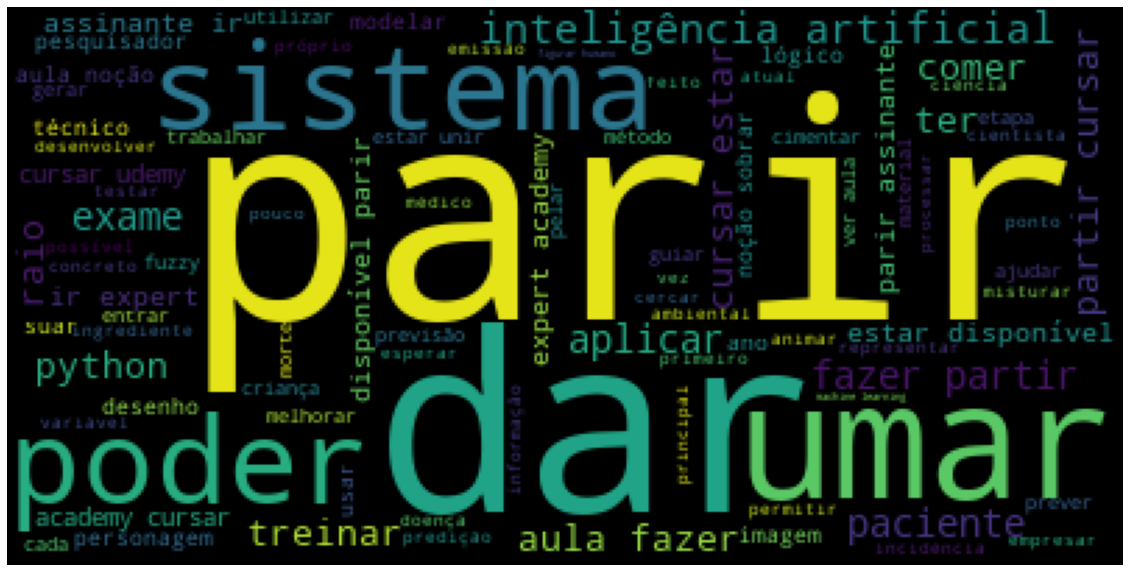

In [120]:
nuvem_palavras(conteudo_feed_formatado)

## Extração de entidades nomeadas

- Siglas: [link](https://spacy.io/api/annotation#named-entities)

In [121]:
documento = pln(conteudo_feed_formatado)

In [122]:
from spacy import displacy
displacy.render(documento, style = 'ent', jupyter = True)

In [123]:
for entidade in documento.ents:
  if entidade.label_ == 'LOC':
    print(entidade.text, entidade.label_)

universidade washington LOC


## Geração de arquivos HTML

In [124]:
def salva_resumo(titulo, lista_sentencas, melhores_sentencas):
  HTML_TEMPLATE = """<html>
    <head>
      <title>{0}</title>
      <meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
    </head>
    <body>{1}</body>

  </html>"""
  texto = ''
  for i in lista_sentencas:
    if i in melhores_sentencas:
      texto += str(i).replace(i, f"<mark>{i}</mark>")
    else:
      texto += i

  arquivo = open(os.path.join(titulo + '.html'), 'wb')
  html = HTML_TEMPLATE.format(titulo + ' - resumo', texto)
  arquivo.write(html.encode('utf-8'))
  arquivo.close()

## Sumarização de artigos de feed de notícias

In [125]:
for artigo in artigos_blog:
  sentencas_originais, melhores_sentencas, _ = sumarizar(artigo['conteudo'], 150, 10, 5)
  visualiza_resumo(artigo['titulo'], sentencas_originais, melhores_sentencas)
  salva_resumo(artigo['titulo'], sentencas_originais, melhores_sentencas)